<a href="https://colab.research.google.com/github/tleitch/BDML/blob/main/linear_models2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import BayesianRidge
from sklearn.tree import DecisionTreeRegressor
import copy 

pd.options.mode.chained_assignment = None  # default='warn'
!pip install mip
from mip import Model, xsum, maximize, BINARY

Regardless, it seems that if we stratify by HR, we have bivariate distributions for runs versus BB. Similarly, if we stratify by BB, we have approximate bivariate normal distributions for HR versus runs. 

###  Multivariate regression

It is somewhat complex to be computing regression lines for each strata. We are essentially fitting models like this:

$$
\mbox{E}[R \mid BB = x_1, \, HR = x_2] = \beta_0 + \beta_1(x_2) x_1 + \beta_2(x_1) x_2
$$

with the slopes for $x_1$ changing for different values of $x_2$ and vice versa. But is there an easier approach?

If we take random variability into account, the slopes in the strata don't appear to change much. If these slopes are in fact the same, this implies that $\beta_1(x_2)$ and $\beta_2(x_1)$ are constants. This in turn implies that the expectation of runs conditioned on HR and BB can be written like this:

$$
\mbox{E}[R \mid BB = x_1, \, HR = x_2] = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

This model suggests that if the number of HR is fixed at $x_2$, we observe a linear relationship between runs and BB with an intercept of $\beta_0 + \beta_2 x_2$. Our exploratory data analysis suggested this. The model also suggests that as the number of HR grows, the intercept growth is linear as well and determined by $\beta_1 x_1$. 

In this analysis, referred to as _multivariate regression_, you will often hear people say that the BB slope $\beta_1$ is _adjusted_ for the HR effect. If the model is correct then confounding has been accounted for. But how do we estimate $\beta_1$ and $\beta_2$ from the data? For this, we learn about linear models and least squares estimates.

## Least squares estimates {#lse}

We have described how if data is bivariate normal then the conditional expectations follow the regression line. The fact that the conditional expectation is a line is not an extra assumption but rather a derived result. However, in practice it is common to explicitly write down a model that describes the relationship between two or more variables using a _linear model_. 

We note that "linear" here does not refer to lines exclusively, but rather to the fact that the conditional expectation is a linear combination of known quantities. In mathematics, when we multiply each variable by a constant and then add them together, we say we formed a linear combination of the variables. For example, $3x - 4y + 5z$ is a linear combination of $x$, $y$, and $z$. We can also add a constant so $2 + 3x - 4y + 5z$ is also linear combination of $x$, $y$, and $z$. 

So $\beta_0 + \beta_1 x_1 + \beta_2 x_2$, is a linear combination of $x_1$ and $x_2$. 
The simplest linear model is a constant $\beta_0$; the second simplest is a line $\beta_0 + \beta_1 x$. If we were to specify a linear model for Galton's data, we would denote the $N$ observed father heights with $x_1, \dots, x_n$, then we model the $N$ son heights we are trying to predict with: 

$$ 
Y_i = \beta_0 + \beta_1 x_i + \varepsilon_i, \, i=1,\dots,N. 
$$

Here $x_i$ is the father's height, which is fixed (not random) due to the conditioning, and $Y_i$ is the random son's height that we want to predict. We further assume that $\varepsilon_i$ are independent from each other, have expected value 0 and the standard deviation, call it $\sigma$, does not depend on $i$. 

In the above model, we know the $x_i$, but to have a useful model for prediction, we need $\beta_0$ and $\beta_1$. We estimate these from the data. Once we do this, we can predict son's heights for any father's height $x$. We show how to do this in the next section.

Note that if we further assume that the $\varepsilon$ is normally distributed, then this model is exactly the same one we derived earlier by assuming bivariate normal data. A somewhat nuanced difference is that in the first approach we assumed the data was bivariate normal and that the linear model was derived, not assumed. In practice, linear models are just assumed without necessarily assuming normality: the distribution of the $\varepsilon$s is not specified.  Nevertheless, if your data is bivariate normal, the above linear model holds. If your data is not bivariate normal, then you will need to have other ways of justifying the model.

### Interpreting linear models

One reason linear models are popular is that they are interpretable. In the case of Galton's data, we can interpret the data like this: due to inherited genes, the son's height prediction grows by $\beta_1$ for each inch we increase the father's height $x$. Because not all sons with fathers of height $x$ are of equal height, we need the term $\varepsilon$, which explains the remaining variability. This remaining variability includes the mother's genetic effect, environmental factors, and other biological randomness. 

Given how we wrote the model above, the intercept $\beta_0$ is not very interpretable as it is the predicted height of a son with a father with no height. Due to regression to the mean, the prediction will usually be a bit larger than 0. To make the slope parameter more interpretable, we can rewrite the model slightly as:

$$ 
Y_i = \beta_0 + \beta_1 (x_i - \bar{x}) + \varepsilon_i, \, i=1,\dots,N 
$$


with $\bar{x} = 1/N \sum_{i=1}^N x_i$ the average of the $x$. In this case $\beta_0$ represents the height when $x_i = \bar{x}$, which is the height of the son of an average father.

### Least Squares Estimates (LSE)

For linear models to be useful, we have to estimate the unknown $\beta$s. The standard approach in science is to find the values that minimize the distance of the fitted model to the data. The following is called the least squares (LS) equation and we will see it often in this chapter. For Galton's data, we would write:

$$ 
RSS = \sum_{i=1}^n \left\{  y_i - \left(\beta_0 + \beta_1 x_i \right)\right\}^2 
$$

This quantity is called the residual sum of squares (RSS). Once we find the values that minimize the RSS, we will call the values the least squares estimates (LSE) and denote them with $\hat{\beta}_0$ and $\hat{\beta}_1$. Let's demonstrate this with the previously defined dataset:



## Case study: Moneyball (continued)

In trying to answer how well BBs predict runs, data exploration led us to a model:

$$
\mbox{E}[R \mid BB = x_1, HR = x_2] = \beta_0 + \beta_1 x_1 + \beta_2 x_2
$$

Here, the data is approximately normal and conditional distributions were also normal. Thus, we are justified in using a linear model:

$$
Y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \varepsilon_i
$$

with $Y_i$ runs per game for team $i$, $x_{i,1}$ walks per game, and $x_{i,2}$. To use `lm` here, we need to let the function know we have two predictor variables. So we use the `+` symbol as follows:

In [ ]:
import pandas as pd
teams = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/teams.csv")
teams = teams[(teams.yearID >=1961) & (teams.yearID <= 2001)]

teams["BB"] = teams["BB"]/teams["G"]
teams["HR"] = teams["HR"]/teams["G"]
teams["R"] = teams["R"]/teams["G"]
team_features_1 = teams[["BB","HR","R"]]
team_runs = teams["R"]
#reg = LinearRegression().fit(team_features_1, team_runs)

### We can get a good summary by using statmodels. Although we do have a choice for using sklearn.
from statsmodels.api import OLS
OLS(team_runs,team_features_1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      R   R-squared (uncentered):                   1.000
Model:                            OLS   Adj. R-squared (uncentered):              1.000
Method:                 Least Squares   F-statistic:                          4.147e+32
Date:                Mon, 29 Mar 2021   Prob (F-statistic):                        0.00
Time:                        12:09:41   Log-Likelihood:                          32562.
No. Observations:                1026   AIC:                                 -6.512e+04
Df Residuals:                    1023   BIC:                                 -6.510e+04
Df Model:                           3                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
BB          -1.11e-16   3.05e-16     -0.365      0.715   -7.09e-16    4.87e-16
HR          6.661e-16   7.43e-16      0.897      0.370   -7.91e-16    2.12e-15
R              1.0000   2.99e-16   3.35e+15      0.000       1.000       1.000
==============================================================================
Omnibus:                      115.627   Durbin-Watson:                   0.039
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              156.422
Skew:                          -0.874   Prob(JB):                     1.08e-34
Kurtosis:                       3.777   Cond. No.                         34.7
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

When we fit the model with only one variable, the estimated slopes were **r bb_slope** and **r hr_slope** for BB and HR, respectively. Note that when fitting the multivariate model both go down, with the BB effect decreasing much more. 

Now we want to construct a metric to pick players, we need to consider singles, doubles, and triples as well. Can we build a model that predicts runs based on all these outcomes? 

We now are going to take somewhat of a "leap of faith" and assume that these five variables are jointly normal. This means that if we pick any one of them, and hold the other four fixed, the relationship with the outcome is linear and the slope does not depend on the four values held constant. If this is true, then a linear model for our data is:

$$
Y_i = \beta_0 + \beta_1 x_{i,1} + \beta_2 x_{i,2} + \beta_3 x_{i,3}+ \beta_4 x_{i,4} + \beta_5 x_{i,5} + \varepsilon_i
$$

with $x_{i,1}, x_{i,2}, x_{i,3}, x_{i,4}, x_{i,5}$ representing BB, singles, doubles, triples, and HR respectively. 


In [ ]:

teams["singles"] = (teams["H"] - teams["X2B"] - teams["X3B"] - teams["HR"])/teams["G"]
teams["doubles"] =  teams["X2B"]/teams["G"]
teams["triples"] = teams["X3B"]/teams["G"]
team_features_2 = teams[["BB","singles","doubles","triples","HR"]]

# regress on "teams" features
reg = LinearRegression().fit(team_features_2, team_runs)


In [ ]:
print ("coefficient of regression: ")
print (reg.coef_)

coefficient of regression: 
[0.37123758 0.51941141 0.77130071 1.23992593 0.92717393]




So instead of using batting average, or just number of HR, as a measure of picking players, we can use our fitted model to form a metric that relates more directly to run production. Specifically, to define a metric for player A, we imagine a team made up of players just like player A and use our fitted regression model to predict how many runs this team would produce. The formula would look like this: 



To define a player-specific metric, we have a bit more work to do. A challenge here is that we derived the metric for teams, based on team-level summary statistics. For example, the HR value that is entered into the equation is HR per game for the entire team. If we compute the HR per game for a player, it will be much lower since the total is accumulated by 9 batters. Furthermore, if a player only plays part of the game and gets fewer opportunities than average, it is still considered a game played. For players, a rate that takes into account opportunities is the per-plate-appearance rate. 

To make the per-game team rate comparable to the per-plate-appearance player rate, we compute the average number of team plate appearances per game:

In [ ]:
batting=pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/Batting.csv")


In [ ]:
def extract_pa_per_game(df):
    
    pa_per_game = (df['AB'].sum() + df["BB"].sum())/df["G"].max()
    
    return pa_per_game


In [ ]:
pa_per_game=batting[batting.yearID ==2002].groupby('teamID').apply(extract_pa_per_game)
average_pa_teamwise = pa_per_game.mean()

We compute the per-plate-appearance rates for players available in 2002 on data from 1997-2001. To avoid small sample artifacts, we filter players with less than 200 plate appearances per year. Here is the entire calculation in one line:

In [ ]:
batting["PA"] = batting["AB"] + batting["BB"]
batting["singles"] = batting["H"] - batting["X2B"] - batting["X3B"] - batting["HR"]

players = batting[(batting.yearID >= 1997) & (batting.yearID <=2001)].groupby('playerID').agg(PA_sum = ("PA",sum),HR_sum=("HR",sum),BB_sum=("BB",sum),singles_sum=("singles",sum),doubles_sum=("X2B",sum),triples_sum=("X3B",sum),AB_sum=("AB",sum),H_sum=("H",sum))
players["Average_PA"] = players["PA_sum"]/average_pa_teamwise
players["HR"] = players["HR_sum"]/players["Average_PA"]
players["BB"] = players["BB_sum"]/players["Average_PA"]
players["singles"] = players["singles_sum"]/players["Average_PA"]
players["doubles"] = players["doubles_sum"]/players['Average_PA']
players["triples"] = players["triples_sum"]/players["Average_PA"]
players["Average"] = players["H_sum"]/players["AB_sum"]
players = players[players.PA_sum >= 1000]

In [ ]:
players_features = players[["HR","BB","singles","doubles","triples"]]
players_features.head()

,HR,BB,singles,doubles,triples
playerID,,,,,
abreubo01,1.321375,5.781016,6.111359,2.257349,0.454223
agbaybe01,1.279368,4.496064,6.287179,1.864222,0.219320
alfoned01,1.214388,4.541305,6.767683,1.998680,0.088549
alicelu01,0.475905,4.283142,6.722153,1.626007,0.436246
alomaro01,1.141080,4.288455,7.310437,2.169306,0.250787


In [ ]:
players_features_save=copy.deepcopy(players_features)
players_features["R_hat"]=(reg.predict(players_features))
players_features_save.head()

,HR,BB,singles,doubles,triples
playerID,,,,,
abreubo01,1.321375,5.781016,6.111359,2.257349,0.454223
agbaybe01,1.279368,4.496064,6.287179,1.864222,0.219320
alfoned01,1.214388,4.541305,6.767683,1.998680,0.088549
alicelu01,0.475905,4.283142,6.722153,1.626007,0.436246
alomaro01,1.141080,4.288455,7.310437,2.169306,0.250787


In [ ]:
master = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/master.csv")
players_features  =  pd.merge(master[["playerID","nameFirst","nameLast"]],players_features,on="playerID")
players_features.head()

,playerID,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat
0,abreubo01,Bobby,Abreu,1.321375,5.781016,6.111359,2.257349,0.454223,8.657520
1,agbaybe01,Benny,Agbayani,1.279368,4.496064,6.287179,1.864222,0.219320,7.404873
2,alfoned01,Edgardo,Alfonzo,1.214388,4.541305,6.767683,1.998680,0.088549,7.820334
3,alicelu01,Luis,Alicea,0.475905,4.283142,6.722153,1.626007,0.436246,7.237259
4,alomaro01,Roberto,Alomar,1.141080,4.288455,7.310437,2.169306,0.250787,8.442398


The player-specific predicted runs computed here can be interpreted as the number of runs we predict a team will score if all batters are exactly like that player. The distribution shows that there is wide variability across players:

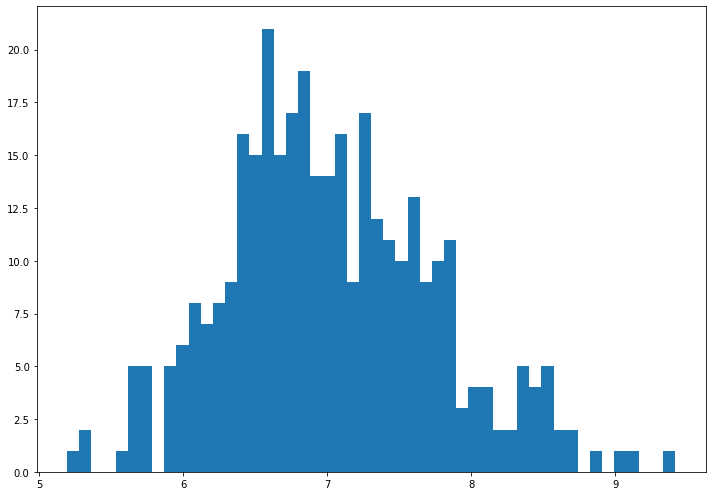

In [ ]:
n_bins = 50
fig, axs = plt.subplots(1, 1,
                        figsize =(10, 7), 
                        tight_layout = True)
#plt.hist(x=players_features["R_hat"])  
hist_df=axs.hist(x=players_features["R_hat"], bins = n_bins)

### Adding salary and position information

To actually build the team, we will need to know their salaries as well as their defensive position. For this, we join the **players** data frame we just created with the player information data frame included in some of the other Lahman data tables. We will learn more about the join function we learned in Section \@ref(joins). 

Start by adding the 2002 salary of each player:

In [ ]:
Salaries=pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/salaries.csv")
salaries_yr_2002 =Salaries[Salaries.yearID==2002]
salaries_yr_2002= salaries_yr_2002[["playerID","salary"]]

In [ ]:
player_insights = pd.merge(salaries_yr_2002, players_features, on='playerID')
player_insights.head()

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat
0,anderga01,5000000,Garret,Anderson,1.245384,1.676031,7.251160,2.234707,0.197865,7.110501
1,erstada01,6250000,Darin,Erstad,0.982139,3.197939,7.198358,2.024164,0.227569,7.529027
2,fabrejo01,500000,Jorge,Fabregas,0.583429,2.230759,6.623638,1.132539,0.171597,5.277921
3,fullmbr01,4000000,Brad,Fullmer,1.433642,2.504095,5.906606,2.676132,0.133807,7.061380
4,glaustr01,4000000,Troy,Glaus,2.105016,5.440932,4.299228,2.015821,0.053517,6.703095


In [ ]:
player_insights = player_insights.sort_values(by=['R_hat'], ascending=False)
player_insights.head()

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat
90,walkela01,12666667,Larry,Walker,2.326584,4.876878,6.845525,2.595036,0.313194,9.415283
222,martied01,7086668,Edgar,Martinez,1.741558,6.311602,6.410414,2.309725,0.049406,9.009369
87,heltoto01,5000000,Todd,Helton,2.240350,4.739202,6.218408,2.742993,0.157973,8.867603
174,willibe02,12357143,Bernie,Williams,1.614440,4.994675,6.937048,2.118953,0.290095,8.670962
194,abreubo01,6333333,Bobby,Abreu,1.321375,5.781016,6.111359,2.257349,0.454223,8.657520


We can see from the above dataframe that there are players whose salary is less but have a better estimate of predicted runs.

Next, we add their defensive position. This is a somewhat complicated task because players play more than one position each year.  However, because some players are traded, they appear more than once on the table, so we first sum their appearances across teams.
We also remove the **OF** position which stands for outfielder, a generalization of three positions: left field (LF), center field (CF), and right field (RF). We also remove pitchers since they don't bat in the league in which the A's play.

In [ ]:
appearances = pd.read_csv("https://raw.githubusercontent.com/tleitch/BDML/main/data/appearances.csv")

In [ ]:
append_str = 'G_'
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
position_names = [append_str + sub for sub in position_names]

In [ ]:
operations_dict = {}
for term in position_names:
    operations_dict[term] = "sum"

In [ ]:
result = appearances[appearances.yearID == 2002].groupby("playerID").agg(operations_dict)

In [ ]:
result.head()

,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh
playerID,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0
abernbr01,0,0,0,116,0,0,0,0,0,1.0
abreubo01,0,0,0,0,0,0,0,18,148,0.0
acevejo01,6,0,0,0,0,0,0,0,0,0.0
aceveju01,65,0,0,0,0,0,0,0,0,0.0


In [ ]:
def max_position(x):
    
    position_counts = [x[term] for term in position_names]
    return position_counts.index(max(position_counts))

In [ ]:
result["most_played_position"] = result.apply(lambda x : position_names[max_position(x)][2:],axis=1)
result.head()


,G_p,G_c,G_1b,G_2b,G_3b,G_ss,G_lf,G_cf,G_rf,G_dh,most_played_position
playerID,,,,,,,,,,,
abbotpa01,7,0,0,0,0,0,0,0,0,0.0,p
abernbr01,0,0,0,116,0,0,0,0,0,1.0,2b
abreubo01,0,0,0,0,0,0,0,18,148,0.0,rf
acevejo01,6,0,0,0,0,0,0,0,0,0.0,p
aceveju01,65,0,0,0,0,0,0,0,0,0.0,p


In [ ]:
player_salary_position = pd.merge(player_insights, result, on='playerID')
player_salary_position.drop(position_names,axis=1,inplace=True)
player_salary_position = player_salary_position[player_salary_position["most_played_position"]!="p"]

In [ ]:
position_names = ["p","c","1b","2b","3b","ss","lf","cf","rf", "dh"]
for position in position_names:
    player_salary_position["chronicle_delta_" + str(position)] = player_salary_position.apply(lambda x : 1 if x.most_played_position == position else 0,axis=1)

### Picking nine players

On average, players with a higher metric have higher salaries

-->
We can search for good deals by looking at players who produce many more runs than others with similar salaries. We can use this table to decide what players to pick and keep our total salary below the 40 million dollars Billy Beane had to work with. This can be done using what computer scientists call linear programming. This is not something we teach, but here are the position players selected with this approach:





In [ ]:
from mip import Model, xsum, maximize, BINARY

In [ ]:
## Here p denotes predicted runs. p[i] denote the runs for the ith player.
## Here w denotes the salary. w[i] denotes the salary for the ith player.
## chronicle_delta_position column of the dataframe denotes whether the player plays on that corresponding position or not.
p = player_salary_position["R_hat"]
w = player_salary_position["salary"]

c, I = 40000000, range(len(w))

In [ ]:
m = Model("knapsack")

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c


for position in position_names:
    m += xsum(player_salary_position["chronicle_delta_" + str(position)][i]*x[i] for i in I) == 1
    


m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))


selected items: [1, 2, 4, 7, 9, 11, 30, 48, 57]


In [ ]:
player_salary_position_clean=player_salary_position.drop(["chronicle_delta_" + str(position) for position in position_names],axis=1)
columns_to_be_rounded = ["HR","BB","singles","doubles","triples",]
for column in columns_to_be_rounded:
    player_salary_position_clean[column] = round(player_salary_position_clean[column],1)
player_salary_position_clean["most_played_position"] = player_salary_position_clean["most_played_position"].apply(lambda x :x.upper())
selected_team=player_salary_position_clean.iloc[selected]
selected_team

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat,most_played_position
1,martied01,7086668,Edgar,Martinez,1.7,6.3,6.4,2.3,0.0,9.009369,DH
2,heltoto01,5000000,Todd,Helton,2.2,4.7,6.2,2.7,0.2,8.867603,1B
4,abreubo01,6333333,Bobby,Abreu,1.3,5.8,6.1,2.3,0.5,8.657520,RF
7,garcino01,9000000,Nomar,Garciaparra,1.7,2.8,7.3,2.6,0.4,8.561981,SS
9,berkmla01,500000,Lance,Berkman,1.9,5.2,5.5,2.8,0.2,8.548005,CF
11,cirilje01,6375000,Jeff,Cirillo,0.8,3.9,7.8,2.3,0.1,8.484743,3B
30,maynebr01,2500000,Brent,Mayne,0.4,3.9,7.6,2.1,0.0,7.886146,C
48,walketo04,2050000,Todd,Walker,0.8,3.3,7.0,2.3,0.2,7.703161,2B
57,millake01,900000,Kevin,Millar,1.4,3.8,6.1,2.3,0.4,7.634930,LF


We see that all these players have above average BB and most have above average HR rates, while the same is not true for singles. Here is a table with statistics standardized across players so that, for example, above average HR hitters have values above 0.







The same pattern arises when we look at the top performers: batting averages go down for most of the top performers.



But these are not rookies! Also, look at what happens to the worst performers of 2013:



Their batting averages mostly go up! Is this some sort of reverse sophomore slump? It is not. There is no such thing as the sophomore slump. This is all explained with a simple statistical fact: the correlation for performance in two separate years is high, but not perfect:



The correlation is **r cor(two_years$"2013",two_years$"2014")** and
the data look very much like a bivariate normal distribution, which means we predict a 2014 batting average $Y$ for any given player that had a 2013 batting average $X$ with:

$$ \frac{Y - .255}{.032} = 0.46 \left( \frac{X - .261}{.023}\right) $$

Because the correlation is not perfect, regression tells us that, on average, expect high performers from 2013 to do a bit worse in 2014. It's not a jinx; it's just due to chance. The ROY are selected from the top values of $X$ so it is expected that $Y$ will regress to the mean.




# Your Turn

In this code that follows you can change the model and call another model. Here is an example of calling a decition tree in Python.



In [ ]:
# Example
reg2 = DecisionTreeRegressor().fit(team_features_2, team_runs)
player_salary_position["R_hat"]=reg2.predict(player_salary_position[["HR","BB","singles","doubles","triples"]])


# Update player info for new predictions
p2 = player_salary_position["R_hat"]
w2 = player_salary_position["salary"]

#players_features_save.head()
#reg2.predict(players_features_save)
#players_features.head()

In [ ]:
# Rerun optimizer
m2 = Model("knapsack")

x2 = [m2.add_var(var_type=BINARY) for i in I]

m2.objective = maximize(xsum(p2[i] * x[i] for i in I))

m2 += xsum(w2[i] * x[i] for i in I) <= c


for position in position_names:
    m2 += xsum(player_salary_position["chronicle_delta_" + str(position)][i]*x[i] for i in I) == 1
    


m2.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))


selected items: [1, 2, 4, 7, 9, 11, 30, 48, 57]


In [ ]:
# Display new team
player_salary_position_clean=player_salary_position.drop(["chronicle_delta_" + str(position) for position in position_names],axis=1)
columns_to_be_rounded = ["HR","BB","singles","doubles","triples",]
for column in columns_to_be_rounded:
    player_salary_position_clean[column] = round(player_salary_position_clean[column],1)
player_salary_position_clean["most_played_position"] = player_salary_position_clean["most_played_position"].apply(lambda x :x.upper())
selected_team=player_salary_position_clean.iloc[selected]
selected_team

,playerID,salary,nameFirst,nameLast,HR,BB,singles,doubles,triples,R_hat,most_played_position
1,martied01,7086668,Edgar,Martinez,1.7,6.3,6.4,2.3,0.0,3.512346,DH
2,heltoto01,5000000,Todd,Helton,2.2,4.7,6.2,2.7,0.2,3.512346,1B
4,abreubo01,6333333,Bobby,Abreu,1.3,5.8,6.1,2.3,0.5,3.512346,RF
7,garcino01,9000000,Nomar,Garciaparra,1.7,2.8,7.3,2.6,0.4,3.512346,SS
9,berkmla01,500000,Lance,Berkman,1.9,5.2,5.5,2.8,0.2,3.512346,CF
11,cirilje01,6375000,Jeff,Cirillo,0.8,3.9,7.8,2.3,0.1,3.512346,3B
30,maynebr01,2500000,Brent,Mayne,0.4,3.9,7.6,2.1,0.0,3.512346,C
48,walketo04,2050000,Todd,Walker,0.8,3.3,7.0,2.3,0.2,3.512346,2B
57,millake01,900000,Kevin,Millar,1.4,3.8,6.1,2.3,0.4,3.512346,LF
